[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/sub-graph.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239937-lesson-2-sub-graphs)

# 서브그래프(Sub-graphs)

## 복습

우리는 이번 강의에서 다룬 모든 모듈을 통합하여 다중 에이전트 기반의 리서치 어시스턴트를 구축해 나가고 있습니다.

방금 전에는 병렬 처리(parallelization)에 대해 살펴보았는데, 이는 LangGraph의 제어 가능성(controllability)과 관련된 중요한 주제 중 하나입니다.

## 목표

이제 [서브그래프(sub-graphs)](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example)에 대해 다뤄보겠습니다.

## 상태(State)

서브그래프를 사용하면 그래프의 서로 다른 부분에서 각각 다른 상태(state)를 생성하고 관리할 수 있습니다.  
이는 특히 각 에이전트가 자체적인 상태를 가진 다중 에이전트 시스템(multi-agent systems)에서 매우 유용합니다.

간단한 예시를 들어보겠습니다:

* 로그를 입력으로 받는 시스템이 있습니다.
* 이 시스템은 서로 다른 에이전트가 두 가지 개별 하위 작업을 수행합니다 (로그 요약하기, 장애 모드 찾기).
* 저는 이 두 작업을 각각 별도의 서브그래프에서 실행하고 싶습니다.

여기서 가장 중요한 핵심은 **그래프 간의 통신 방식**입니다!

간단히 말해, 통신은 **키(key)의 중첩(overlapping)** 을 통해 이루어집니다:

* 서브그래프는 부모 그래프의 `docs`에 접근할 수 있습니다.
* 부모 그래프는 서브그래프에서 생성된 `summary` 또는 `failure_report`에 접근할 수 있습니다.

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## 입력(Input)

이제 그래프에 입력될 로그 데이터의 스키마를 정의해 보겠습니다.

In [6]:
%%capture --no-stderr
%pip install -U  langgraph

In [7]:
from dotenv import load_dotenv

load_dotenv("../.env", override=True)

True

In [8]:
import os
import getpass


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [9]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated


# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

## 서브 그래프 (Sub-graphs)

다음은 `FailureAnalysisState`를 사용하는 실패 분석 서브 그래프입니다.

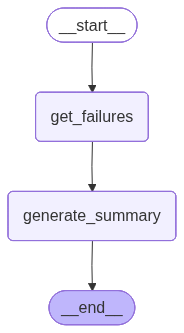

In [10]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# 고장 분석 하위 그래프
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]


class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]


def get_failures(state):
    """실패를 포함하는 로그를 가져옵니다"""
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}


def generate_summary(state):
    """실패 요약 생성"""
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "크로마 문서 검색 품질이 낮음."
    return {
        "fa_summary": fa_summary,
        "processed_logs": [
            f"failure-analysis-on-log-{failure['id']}" for failure in failures
        ],
    }


fa_builder = StateGraph(
    state_schema=FailureAnalysisState, output_schema=FailureAnalysisOutputState
)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

다음은 `QuestionSummarizationState`를 사용하는 질문 요약 서브 그래프입니다.

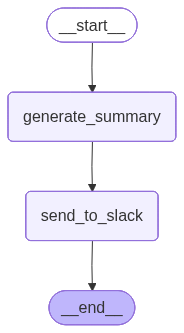

In [11]:
# 요약 부분 그래프
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]


class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]


def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "질문은 ChatOllama와 Chroma 벡터 저장소의 사용법에 집중되었습니다."
    return {
        "qs_summary": summary,
        "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs],
    }


def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


qs_builder = StateGraph(
    QuestionSummarizationState, output_schema=QuestionSummarizationOutputState
)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## 상위 그래프에 서브 그래프 추가하기

이제 이 모든 것을 하나로 합쳐보겠습니다.

먼저 `EntryGraphState`로 상위 그래프를 생성합니다.

그리고 서브 그래프들을 노드로 추가합니다\!

```python
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [12]:
# 엔트리 그래프 (Entry Graph)
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add]  # 두 서브 그래프 모두에서 사용될 것입니다
    fa_summary: str  # FA 서브 그래프에서만 생성될 것입니다
    report: str  # QS 서브 그래프에서만 생성될 것입니다
    processed_logs: Annotated[List[int], add]  # 두 서브 그래프 모두에서 생성될 것입니다

하지만 `cleaned_logs`는 수정되지 않고 각 서브 그래프에 입력으로만 사용되는데, 왜 리듀서(reducer)가 필요할까요?

```python
cleaned_logs: Annotated[List[Log], add] # 두 서브 그래프 모두에서 사용될 것입니다
```

그 이유는 서브 그래프의 출력 상태(state)가 수정되지 않은 키를 포함하여 **모든 키**를 담고 있기 때문입니다.

서브 그래프는 병렬로 실행됩니다.

병렬로 실행되는 서브 그래프들이 동일한 키를 반환하므로, 각 서브 그래프에서 들어오는 값들을 하나로 합치려면 `operator.add`와 같은 리듀서가 필요합니다.

하지만 이전에 다루었던 다른 개념을 사용하면 이 문제를 해결할 수 있습니다.

각 서브 그래프에 대한 출력 상태 스키마를 만들고, 이 스키마가 출력할 서로 다른 키를 갖도록 하면 됩니다.

사실 각 서브 그래프가 `cleaned_logs`를 출력할 필요는 없습니다.

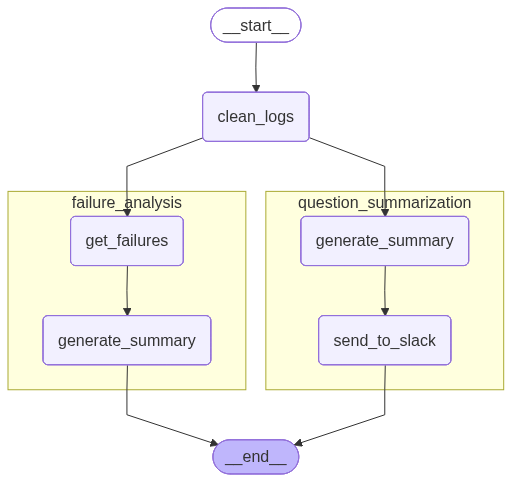

In [13]:
# 엔트리 그래프(Entry Graph)
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str  # FA 서브 그래프에서만 생성됩니다
    report: str  # QS 서브 그래프에서만 생성됩니다
    processed_logs: Annotated[List[int], add]  # 두 서브 그래프 모두에서 생성됩니다


def clean_logs(state):
    # 로그 가져오기
    raw_logs = state["raw_logs"]
    # 데이터 정제: raw_logs -> docs
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# xray를 1로 설정하면 중첩된 그래프의 내부 구조를 볼 수 있습니다.
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [14]:
# 더미 로그(Dummy logs)
question_answer = Log(
    id="1",
    question="ChatOllama를 어떻게 임포트(import)할 수 있나요?",
    answer="'from langchain_community.chat_models import ChatOllama' 코드를 사용하여 ChatOllama를 임포트하세요.",
)

question_answer_feedback = Log(
    id="2",
    question="Chroma 벡터 스토어를 어떻게 사용할 수 있나요?",
    answer="Chroma를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'과 같이 정의하세요.",
    grade=0,
    grader="문서 관련성 재현율(Document Relevance Recall)",
    feedback="검색된 문서는 벡터 스토어에 대해 전반적으로 설명하고 있지만, Chroma에 대해 특정하지는 않았습니다.",
)

raw_logs = [question_answer, question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'ChatOllama를 어떻게 임포트(import)할 수 있나요?',
   'answer': "'from langchain_community.chat_models import ChatOllama' 코드를 사용하여 ChatOllama를 임포트하세요."},
  {'id': '2',
   'question': 'Chroma 벡터 스토어를 어떻게 사용할 수 있나요?',
   'answer': "Chroma를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'과 같이 정의하세요.",
   'grade': 0,
   'grader': '문서 관련성 재현율(Document Relevance Recall)',
   'feedback': '검색된 문서는 벡터 스토어에 대해 전반적으로 설명하고 있지만, Chroma에 대해 특정하지는 않았습니다.'}],
 'cleaned_logs': [{'id': '1',
   'question': 'ChatOllama를 어떻게 임포트(import)할 수 있나요?',
   'answer': "'from langchain_community.chat_models import ChatOllama' 코드를 사용하여 ChatOllama를 임포트하세요."},
  {'id': '2',
   'question': 'Chroma 벡터 스토어를 어떻게 사용할 수 있나요?',
   'answer': "Chroma를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'과 같이 정의하세요.",
   'grade': 0,
   'grader': '문서 관련성 재현율(Document Relevance Recall)',
   'feedback': '검색된 문서는 벡터 스토어에 대해 전반적으로 설명하고 있지만, Chroma에 대해 특정하

## LangSmith

Let's look at the LangSmith trace:

https://smith.langchain.com/public/f8f86f61-1b30-48cf-b055-3734dfceadf2/r